In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

import timeit
import json
import cv2, random

%load_ext autoreload
%autoreload 2

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
Joints = json.load(open("Dataset/annotation.json","r"))
names = Joints.keys()

In [5]:
import show

Joints = json.load(open("Dataset/annotation.json","r"))
names = Joints.keys()
random.shuffle(names)
LeftJoints = {}
RightJoints = {}

093_1673_R
021_1163_R


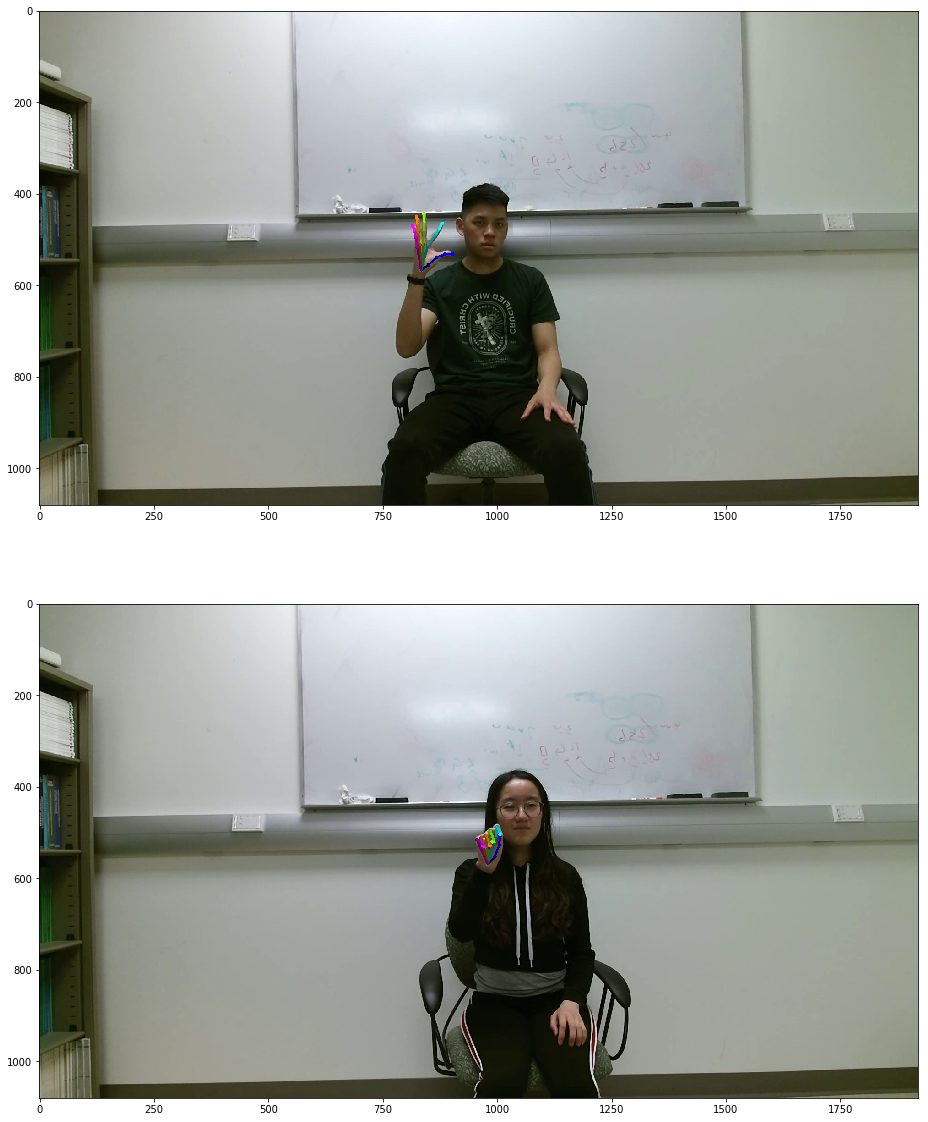

In [6]:
num = 2
fix, ax = plt.subplots(num, 1, figsize=(20,num*10))
for j, name in enumerate(names[:num]):
    canvas = cv2.imread("Dataset/Images/" + name[:-2] + ".jpg")
    tmp = []
    print name
    for i in xrange(len(Joints[name])):
        tmp.append([int(Joints[name][i][0]), int(Joints[name][i][1])])
    # print tmp
    canvas = show.draw_hand(canvas, tmp)
    ax[j].imshow(canvas[:,:,::-1])

In [ ]:
from cs175utils.features import color_histogram_hsv, hog_feature

def load_data(num_training=1000, num_validation=100, num_test=10):
    pass
    
X_train, y_train, X_val, y_val, X_test, y_test = load_data()